In [1]:
# Load Dataset

import json
import numpy as np
FILE_PATH = "./data/"
FILE_NAME = "3squats.json"
# dataDictList is a list of dicts
with open(FILE_PATH+FILE_NAME, 'r') as f:
    dataDictList = json.load(f)



In [2]:
# Global constants

PARTS =  {"nose" : 0, 
  "leftEye" : 1, 
  "rightEye" : 2, 
  "leftEar" : 3, 
  "rightEar" : 4, 
  "leftShoulder" : 5, 
  "rightShoulder" : 6, 
  "leftElbow" : 7, 
  "rightElbow" : 8, 
  "leftWrist" : 9, 
  "rightWrist" : 10, 
  "leftHip" : 11, 
  "rightHip" : 12, 
  "leftKnee" : 13, 
  "rightKnee" : 14, 
  "leftAnkle" : 15, 
  "rightAnkle" : 16}

requiredParts = ["nose", 
  "leftEye", 
  "rightEye", 
  "leftEar", 
  "rightEar", 
  "leftShoulder", 
  "rightShoulder", 
  "leftElbow", 
  "rightElbow", 
  "leftWrist", 
  "rightWrist", 
  "leftHip", 
  "rightHip", 
  "leftKnee", 
  "rightKnee", 
  "leftAnkle", 
  "rightAnkle"
]

IMAGE_X_SIZE = 600
IMAGE_Y_SIZE = 450



In [3]:
len(dataDictList[0]['keypoints'])



17

In [4]:
# Generate List that we want

dataListX = None
dataListY = None
for _frame in range(0,len(dataDictList)):
    if dataListX is None:
        print(_frame)
        dataListX = [[dataDictList[_frame]['keypoints'][PARTS[X]]['position']['x'] for X in requiredParts]]
        dataListY = [[dataDictList[_frame]['keypoints'][PARTS[X]]['position']['y'] for X in requiredParts]]
    else:
        dataListX = dataListX + [[dataDictList[_frame]['keypoints'][PARTS[_part]]['position']['x'] for _part in requiredParts]]
        dataListY = dataListY + [[dataDictList[_frame]['keypoints'][PARTS[_part]]['position']['y'] for _part in requiredParts]]



0


In [5]:
dataListX = np.array(dataListX) # [[x]]
dataListY = np.array(dataListY) # [[y]]
print(dataListX.shape, dataListY.shape)
newDataListX = np.reshape(dataListX, (-1,len(requiredParts))) 
newDataListY = np.reshape(dataListY, (-1,len(requiredParts))) #[#instance, (y) for each keypoint]
print(newDataListX.shape, newDataListY.shape)
# newDataListX[:,0]

(265, 17) (265, 17)
(265, 17) (265, 17)


array([303.9583821 , 358.44431765, 341.66549789, 334.13699543,
       317.81722179, 316.26137748, 315.08599355, 314.39505539,
       316.98660338, 317.23938867, 319.09368778, 319.46623972,
       322.47816438, 322.98277312, 325.46062829, 332.40654188,
       331.26313016, 327.96347343, 314.12705881, 304.44954293,
       296.26909237, 295.20230708, 296.55486514, 296.12410418,
       297.60483607, 303.73008805, 311.68790872, 313.56712656,
       312.61832674, 312.09521152, 309.94028458, 306.71468938,
       305.86141433, 303.74494311, 303.15359081, 303.56174858,
       303.24867029, 302.43340566, 301.65889446, 300.85951797,
       301.78033542, 299.90074354, 299.84264139, 298.56866906,
       298.04852841, 297.89377935, 296.89460772, 298.50761016,
       297.97663992, 298.61013497, 298.31798556, 298.44965051,
       299.59858389, 299.11388875, 299.36963081, 297.65563537,
       296.07882655, 295.51917929, 294.96633614, 299.38430774,
       314.54745329, 318.93965119, 311.14979595, 311.73

In [6]:
# Normalization
'''
 This has 2 parts-
 Resize, by identifying and scaling as bounding box, and then (Min-Max) Normalize
 Note: The broadcasting here is element-wise. 
 Sources:
 [1] https://medium.com/tensorflow/move-mirror-an-ai-experiment-with-pose-estimation-in-the-browser-using-tensorflow-js-2f7b769f9b23
 [2] https://raw.githubusercontent.com/paulvollmer/posenet-keypoints-normalization/master/src/index.js
 

''' 

def scale(newDataListX, newDataListY):
    '''
    Assumes dataList of form [#instance, [(x,y) for each keypoint]]
    Possible optim: bounding box wont change much across frames
    '''
    # Bounding Box
    maxX = np.max(newDataListX, axis=1)
    minX = np.min(newDataListX, axis=1)
    maxY = np.max(newDataListY, axis=1)
    minY = np.min(newDataListY, axis=1)
    assert(len(minY)==len(newDataListX))
    scaledDataX = newDataListX.copy()
    scaledDataY = newDataListY.copy()
    l2Data = np.concatenate((newDataListX, newDataListY), axis=1)
    print(l2Data.shape)
    # Reset to Origin and Scale
    for _data in range(0, len(newDataListX)):
        scaledDataX[_data] = (newDataListX[_data] - minX[_data]) * (IMAGE_X_SIZE/((maxX[_data]-minX[_data])+10e-5))
        scaledDataY[_data] = (newDataListY[_data] - minY[_data]) * (IMAGE_Y_SIZE/((maxY[_data]-minY[_data])+10e-5))
        l2Data[_data] = l2Data[_data] / np.linalg.norm(l2Data[_data]) # L2 norm if the need be
    return scaledDataX, scaledDataY, l2Data

scaledDataX, scaledDataY, l2Data = scale(newDataListX, newDataListY)

(265, 34)


In [7]:
scaledDataX = l2Data[:,:17]
scaledDataY = l2Data[:,17:]

<IPython.core.display.Javascript object>


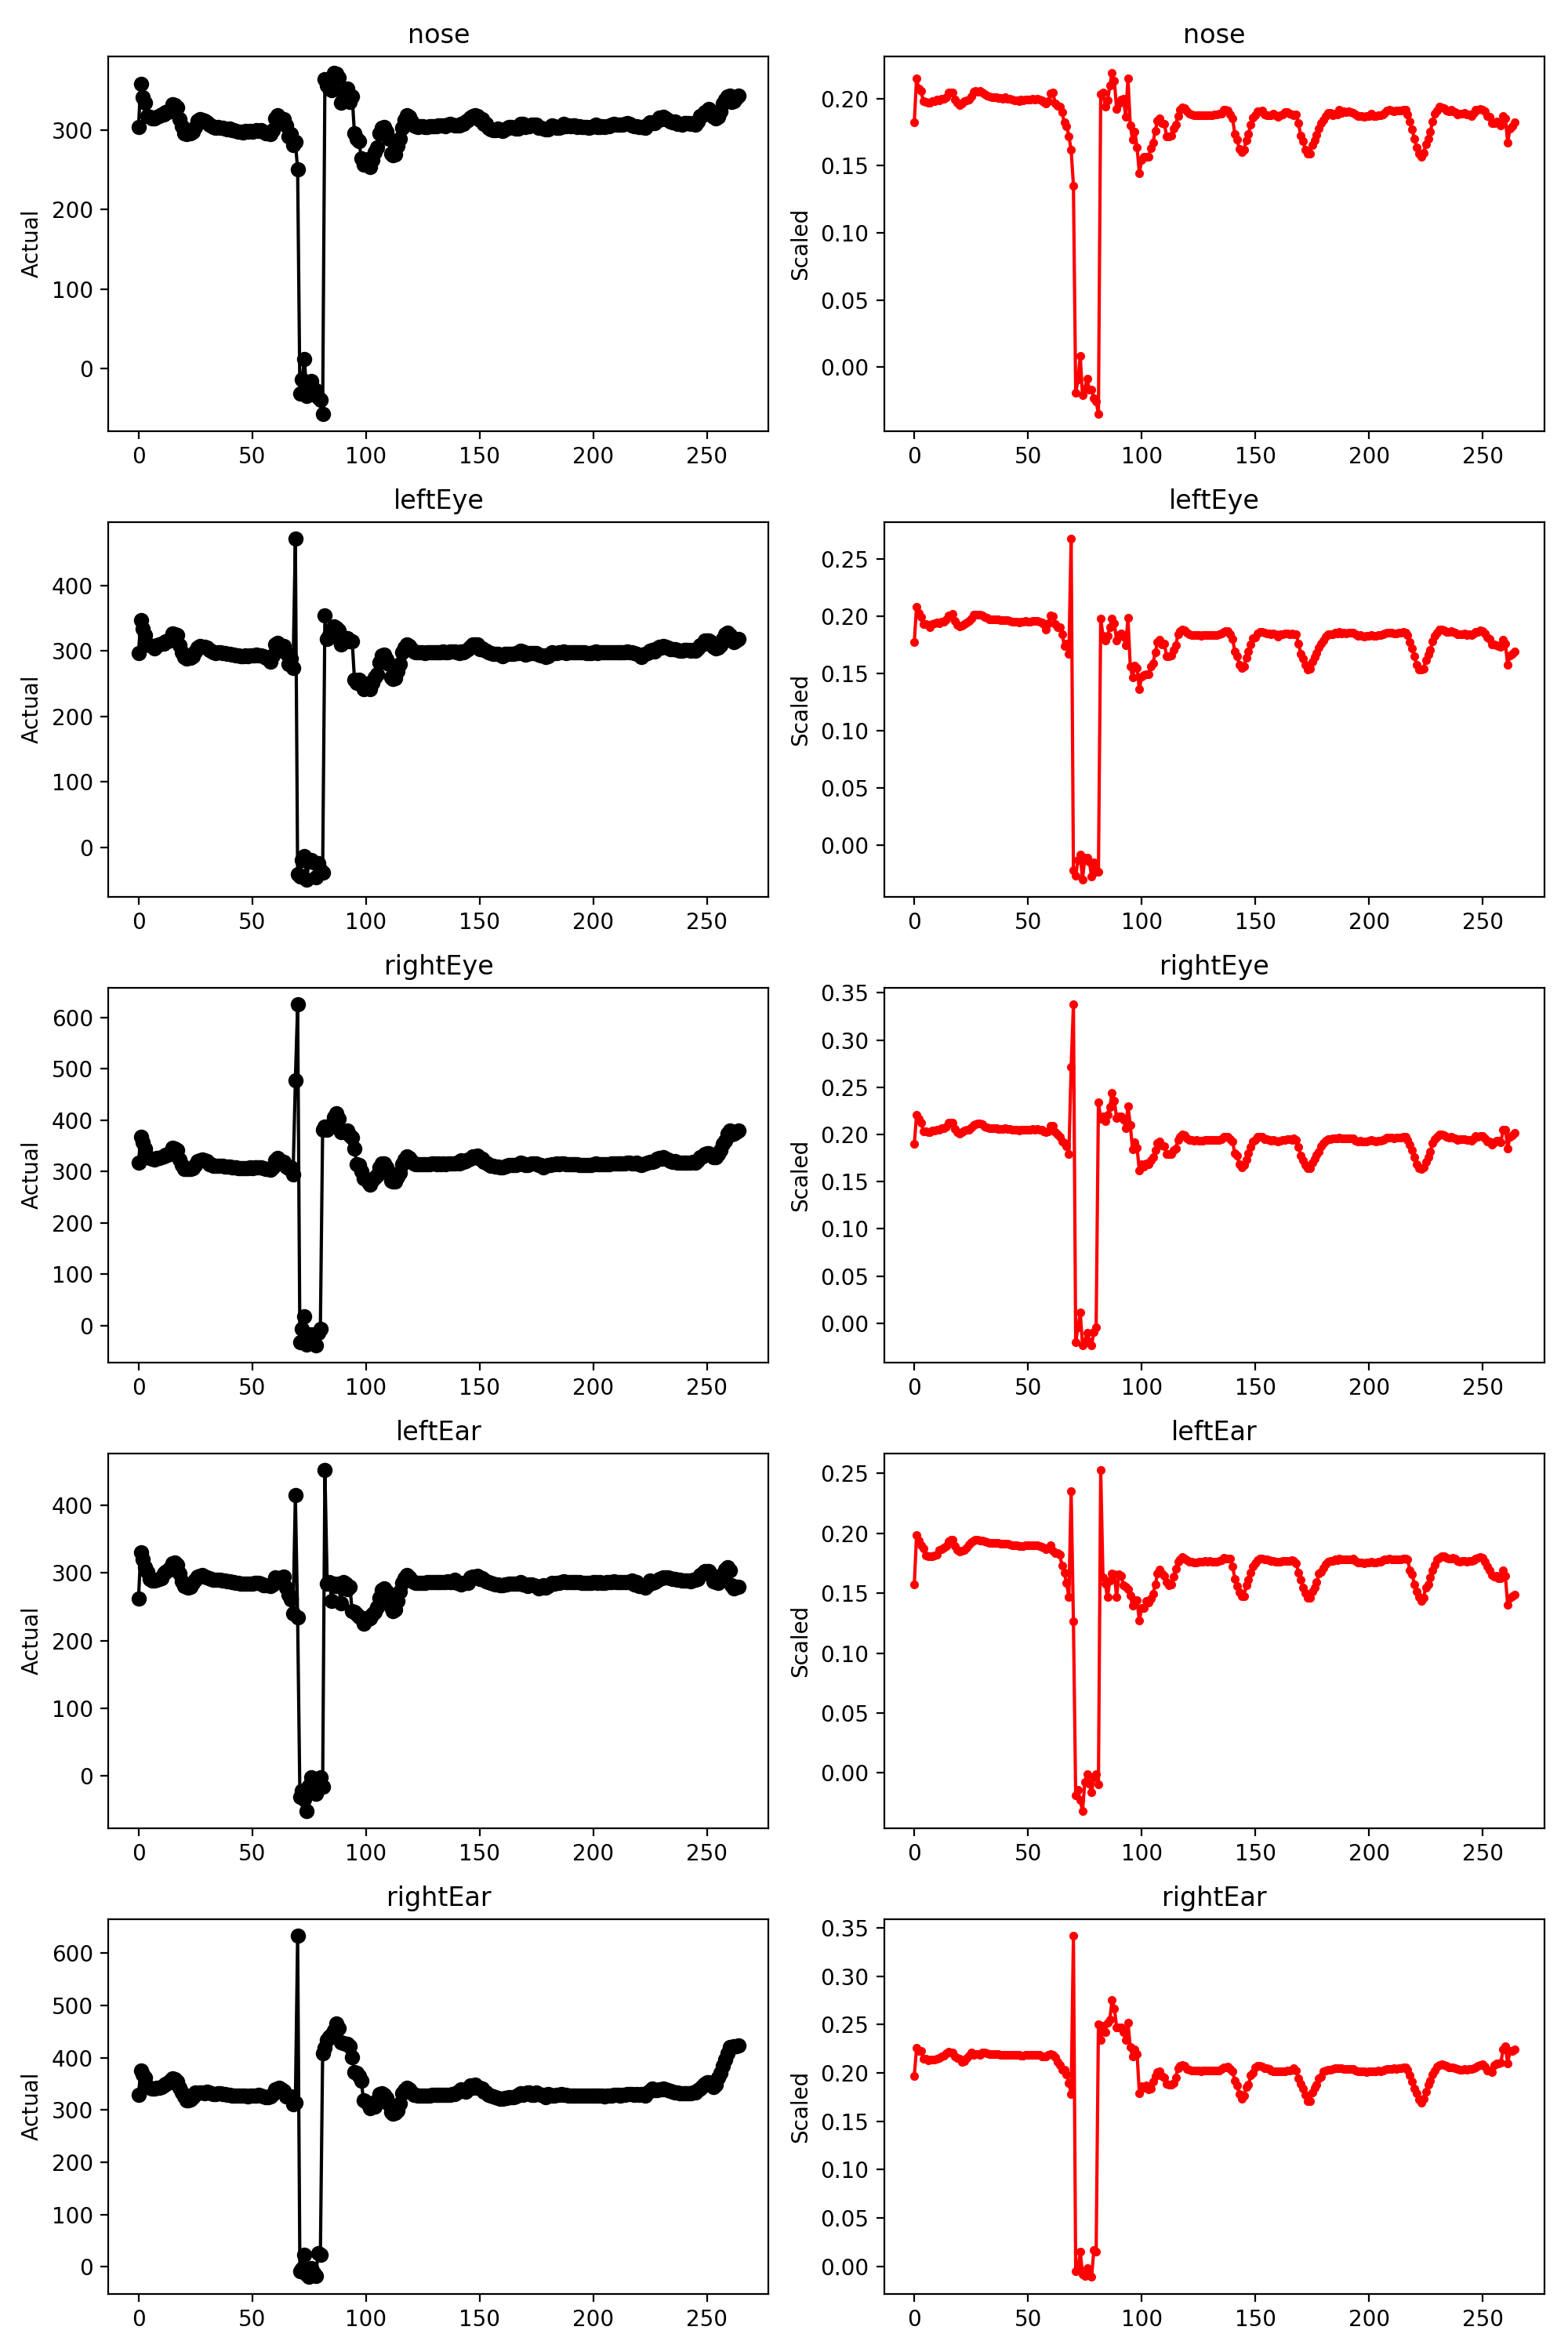

In [8]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
num_graphs = 5
index = 0
for sub in range(0, num_graphs, 1):
    plt.subplot(5, 2, 2*sub+1)
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')

    plt.subplot(5, 2, 2*sub+2)
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled')
    index = index + 1

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


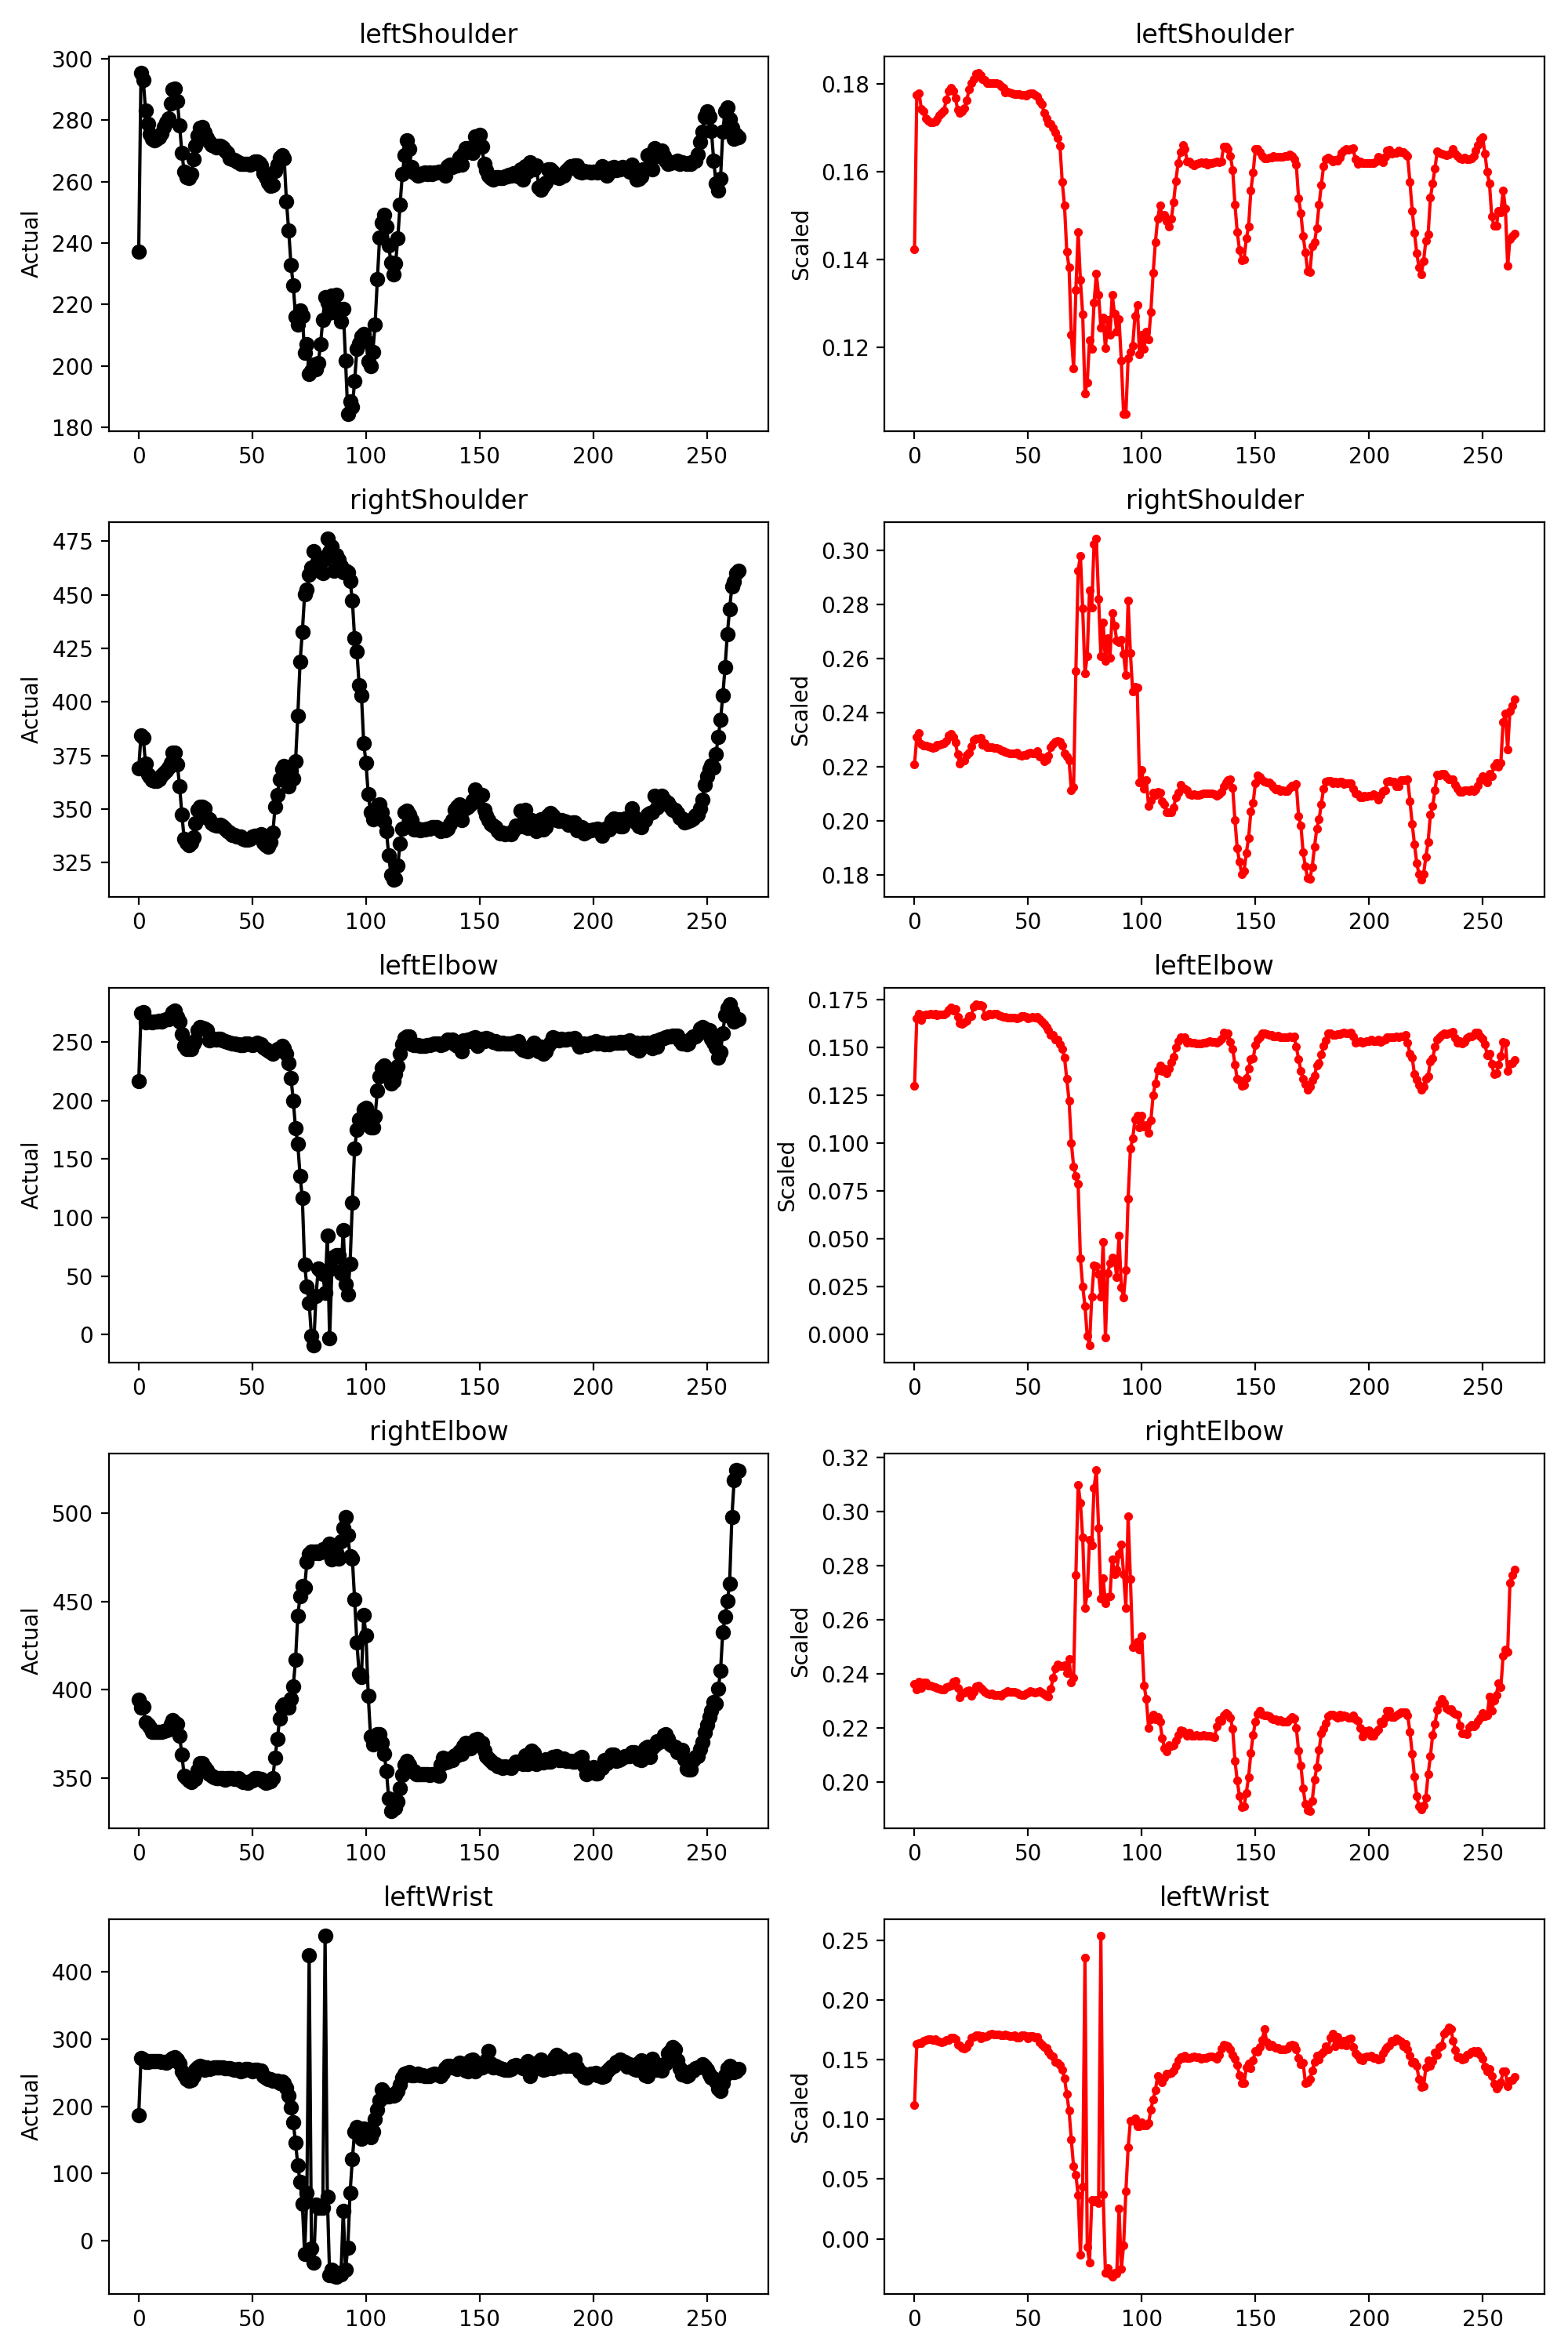

In [9]:
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
for sub in range(0, 5, 1):
    plt.subplot(5, 2, 2*sub+1)
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')
    plt.subplot(5, 2, 2*sub+2)
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled')
    index = index+1
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


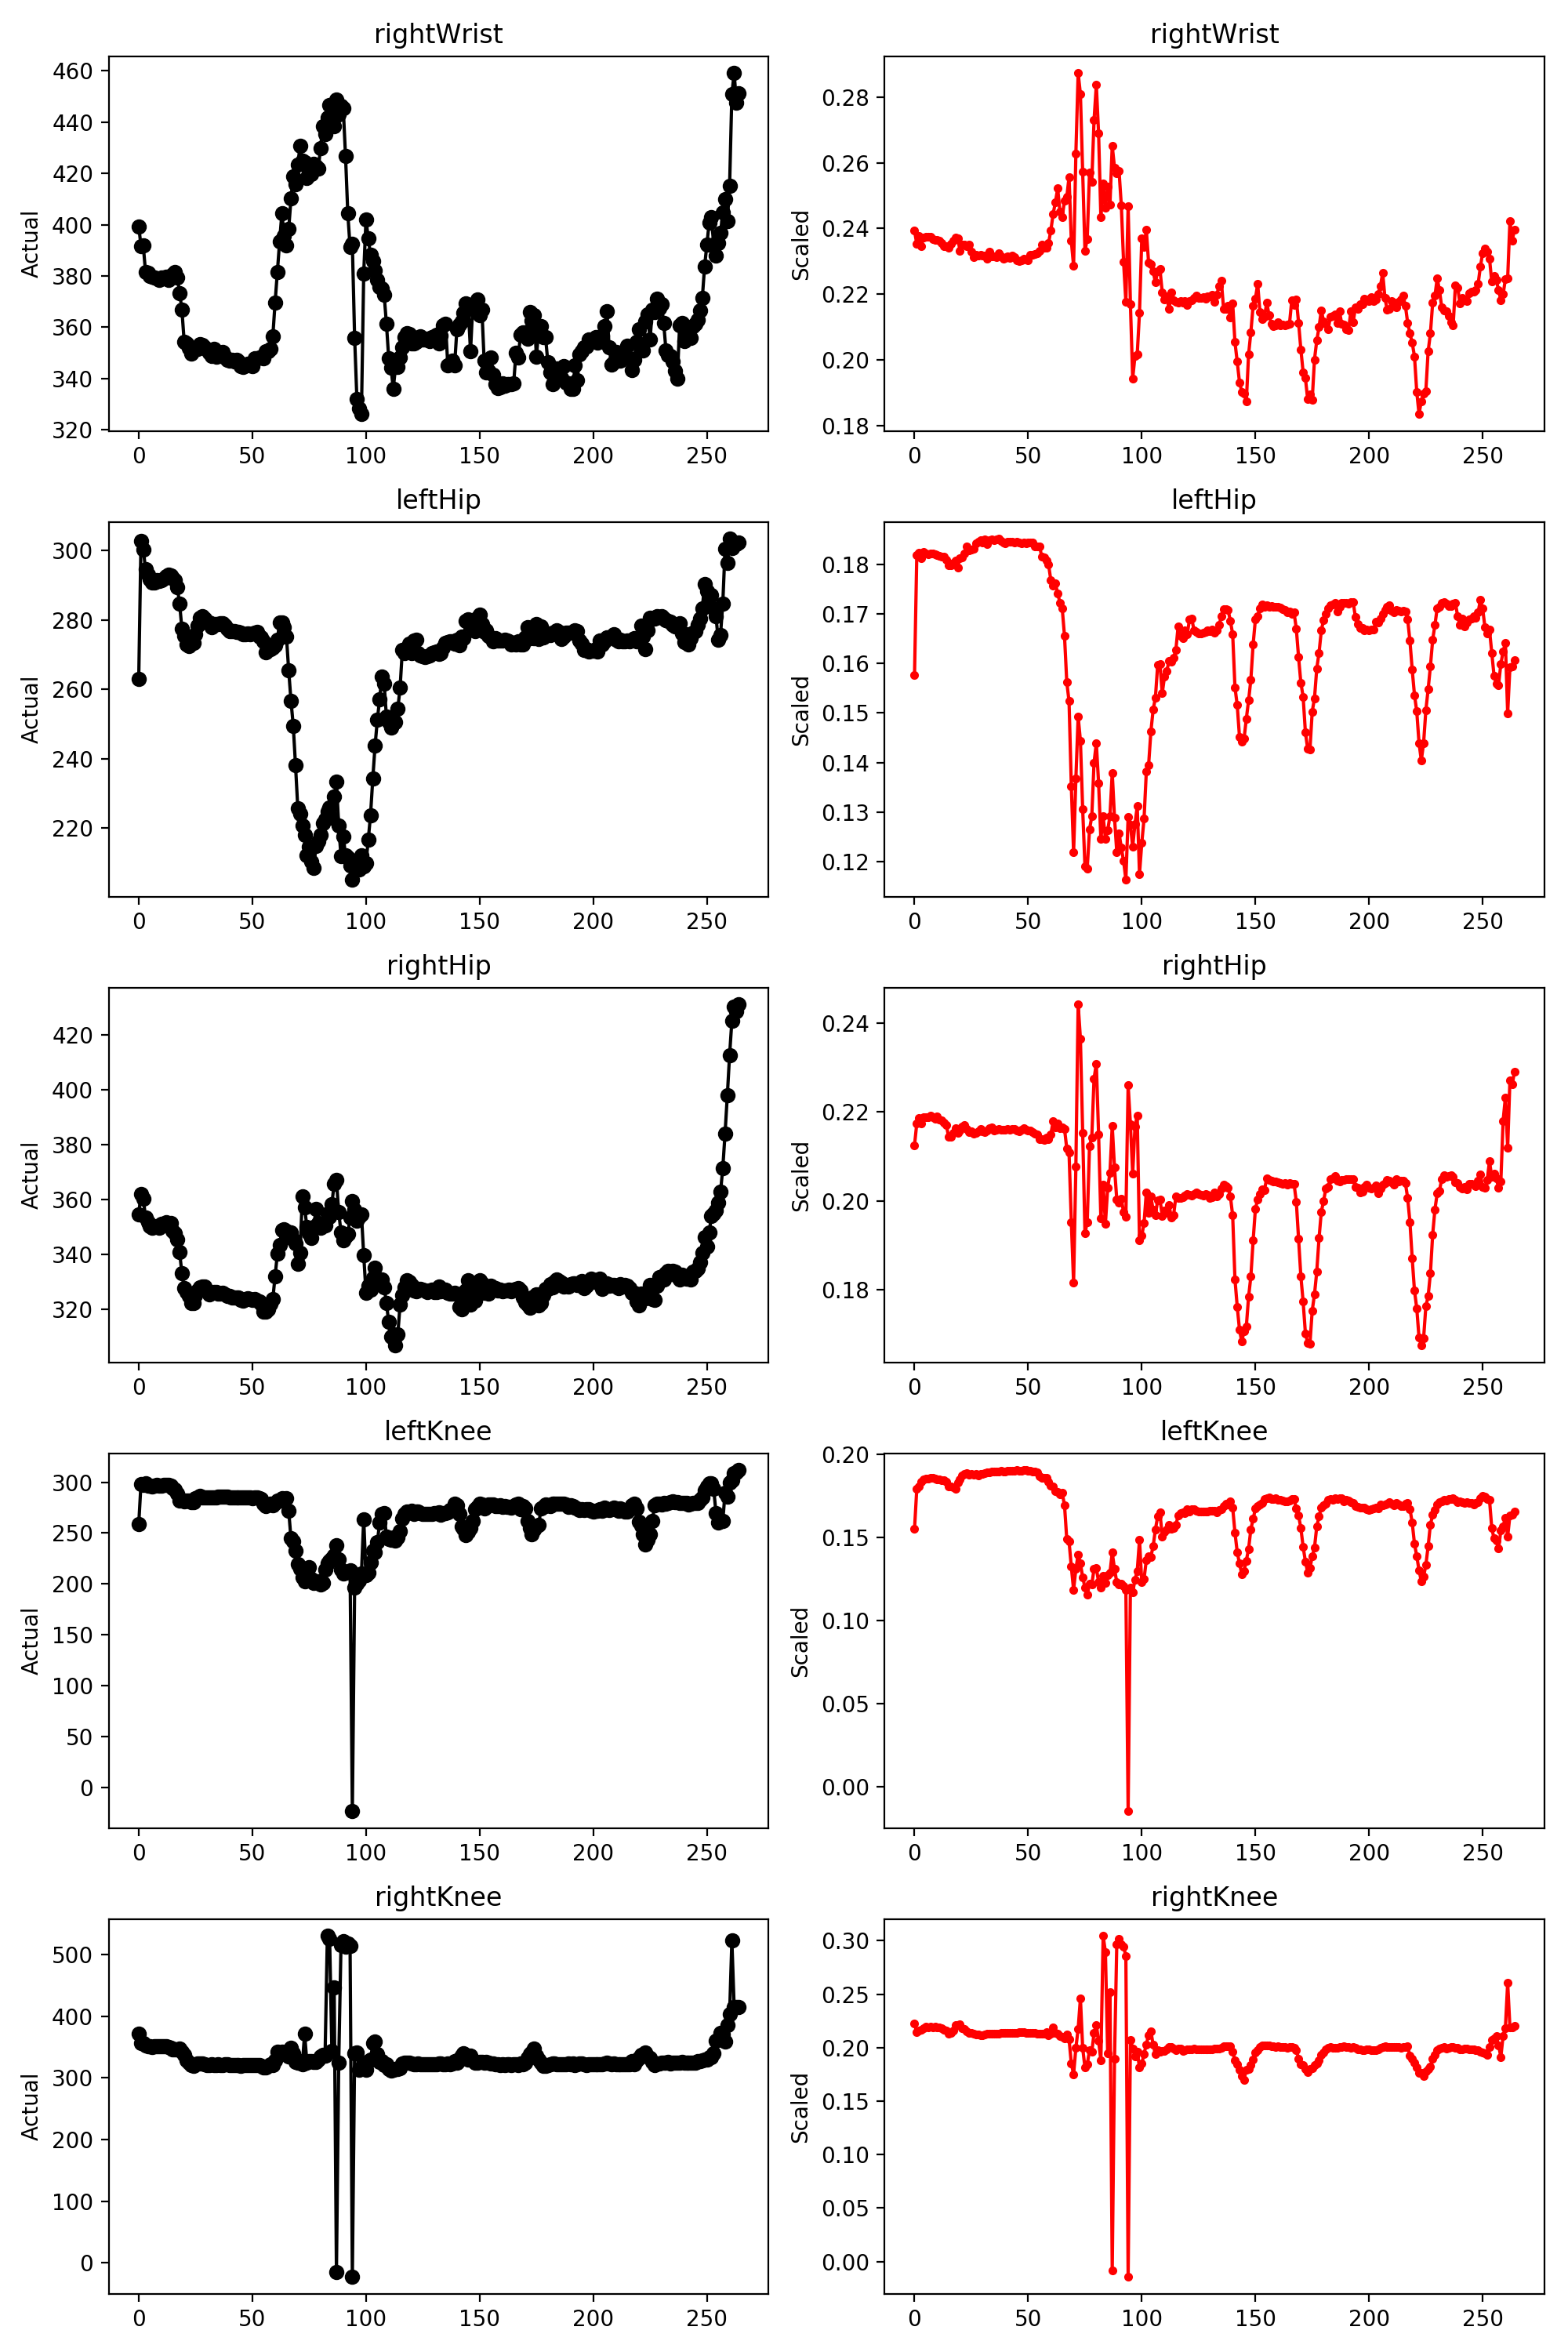

In [10]:
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
for sub in range(0, 5, 1):
    plt.subplot(5, 2, (2*sub+1))
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')
    plt.subplot(5, 2, (2*sub+2))
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled')
    index = index+1
    
plt.tight_layout()
plt.show()